In [10]:
# Load Libraries

import os
from torchvision.datasets.folder import default_loader
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 
import torch.nn.functional as F

In [2]:
# Load Libraries

import os
from torchvision.datasets.folder import default_loader
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 
import torch.nn.functional as F
# Define your transformations
augment_transforms = [
    transforms.Compose([
        transforms.Resize((256, 256)),  # Resize if necessary
        transforms.ToTensor()           # Convert to tensor
    ]),
]

root_direct = os.path.dirname('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/')
sequences = []  # This will hold the training sequences

# Define the sequence function
def get_sequences_from_folder(folder_path, stride, sequence_length=10):
    image_files = sorted([file for file in os.listdir(folder_path) if file.endswith('.tif')])
    sequences = []
    for start_idx in range(0, len(image_files), stride * sequence_length):
        sequence_files = image_files[start_idx:start_idx + stride * sequence_length:stride]
        if len(sequence_files) == sequence_length:
            sequence = [default_loader(os.path.join(folder_path, f)) for f in sequence_files]
            transformed_sequence = [augment_transforms[0](img) for img in sequence]
            sequence_tensor = torch.stack(transformed_sequence, dim=0)
            sequences.append(sequence_tensor)
    return sequences

# Generate sequences with different strides
for subfolder in os.listdir(root_direct):
    subfolder_path = os.path.join(root_direct, subfolder)
    if os.path.isdir(subfolder_path):
        for stride in range(1, 3):  # Here, we use stride values of 1 and 2
            sequences.extend(get_sequences_from_folder(subfolder_path, stride))

# Stack all the sequences together to create the final dataset tensor
sequences_tensor = torch.stack(sequences, dim=0)
print(sequences_tensor.shape)

# Create the dataset from the tensor
dataset = TensorDataset(sequences_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


torch.Size([1020, 10, 3, 256, 256])


In [ ]:
def plot_image_tensor(tensor_image):
    # CxHxW to HxWxC or getting invalid dimensions
    tensor_image = tensor_image.permute(1, 2, 0)  
    plt.imshow(tensor_image.numpy())
    plt.title('Single Image')
    plt.axis('off') 
    plt.show()

# Testing the dataset
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create an iterator from the DataLoader
train_loader_iter = iter(train_loader)

# Fetch the next batch
batch = next(train_loader_iter) 

print(batch[0].shape)

plot_image_tensor(batch[0][0][0])  # Plot the first image from the batch

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.gates = nn.Conv2d(in_channels=input_channels + hidden_channels,
                               out_channels=4 * hidden_channels,  # for input, forget, cell, and output gates
                               kernel_size=kernel_size,
                               padding=self.padding)

    def forward(self, input_tensor, hidden_state):
        h_cur, c_cur = hidden_state
        # print("[input_tensor, h_cur]", [input_tensor.size(), h_cur.size()])
        # concatenate along the channel dimension
        combined = torch.cat([input_tensor, h_cur], dim=1)
        gates = self.gates(combined)

        # Split the combined gate tensor into its components
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        output_gate = torch.sigmoid(output_gate)

        c_next = forget_gate * c_cur + input_gate * cell_gate
        h_next = output_gate * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device),
                torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device))


class ConvLSTM(nn.Module):
    def __init__(self):
        super(ConvLSTM, self).__init__()
        # Spatial Encoder
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=128, kernel_size=11, stride=4, padding=(11-1)//2)
        self.bn1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(
            in_channels=128, out_channels=64, kernel_size=5, stride=2, padding=(5-1)//2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.5)
        

        # Temporal Encoder (ConvLSTM)
        self.convlstm1 = ConvLSTMCell(
            input_channels=64, hidden_channels=64, kernel_size=3)
        self.convlstm2 = ConvLSTMCell(
            input_channels=64, hidden_channels=32, kernel_size=3)
        self.convlstm3 = ConvLSTMCell(
            input_channels=32, hidden_channels=64, kernel_size=3)
        # Spatial Decoder
        self.deconv1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.5)

        self.deconv2 = nn.ConvTranspose2d(
            in_channels=64, out_channels=128, kernel_size=12, stride=4, padding=4, output_padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(
            in_channels=128, out_channels=3, kernel_size=11, padding=(11-1)//2)

    def forward(self, x):
        # Initialize hidden states and cell states
        b, seq_len, _, h, w = x.size()
        # print("x.size()", x.size())
        h1, c1 = self.convlstm1.init_hidden(b, (h//8, w//8))
        h2, c2 = self.convlstm2.init_hidden(b, (h//8, w//8))
        h3, c3 = self.convlstm3.init_hidden(b, (h//8, w//8))
        output_sequence = []

        for t in range(seq_len):
            # Spatial Encoder
            xt = self.conv1(x[:, t])
            xt = self.bn1(xt)
            xt = self.dropout1(xt)
            xt = F.relu(xt)

            xt = self.conv2(xt)
            xt = self.bn2(xt)
            xt = self.dropout2(xt)
            xt = F.relu(xt)

            # Temporal Encoder
            h1, c1 = self.convlstm1(xt, (h1, c1))
            h2, c2 = self.convlstm2(h1, (h2, c2))
            h3, c3 = self.convlstm3(h2, (h3, c3))

            # Spatial Decoder
            xt = self.deconv1(xt)
            xt = self.bn3(xt)
            xt = self.dropout3(xt)
            xt = F.relu(xt)

            xt = self.deconv2(xt)
            xt = self.bn4(xt)
            xt = self.dropout4(xt)
            xt = F.relu(xt)

            xt = torch.sigmoid(self.conv3(xt))

            output_sequence.append(xt.unsqueeze(1))

        # Concatenate along the sequence dimension

        output_sequence = torch.cat(output_sequence, dim=1)
        return output_sequence

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Testing the dataset
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Instantiate the model
model = ConvLSTM()
model = nn.DataParallel(model)
model.to(device)

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5, eps=1e-6)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'  # Path to save the best model

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0

    for (images,) in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Training Loss: {average_loss:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (images,) in val_loader:
            images = images.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, images).item()

    val_loss /= len(val_loader)
    print(f'Validation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Early stopping check and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print(f'Model saved at epoch {epoch + 1}')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch + 1}')
        break

# Load the best model after training
best_model = ConvLSTM()
best_model = nn.DataParallel(best_model)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()
# Now best_model holds the best model state

In [ ]:
# Save the entire model
torch.save(model, 'model.pth')

In [ ]:
# Load the model
model = torch.load('model.pth')

model.to(device)
# Dummy input of shape (batch_size, sequence_length, channels, height, width)
# Assuming batch_size=1 and sequence_length=10 for this example


torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

image = batch[0].to(device)
 

 
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(image)
    print("Output shape:", output.shape)

# Convert to NumPy arrays for visualization
np_image = image.squeeze().cpu().numpy()
np_output = output.squeeze().cpu().numpy()

print(np_image.shape)
print(np_output.shape)


# If the images have channels as the first dimension, transpose them to (H, W, C)
if np_image.shape[0] in (1, 3):
    np_image = np_image.transpose(1, 2, 0)
if np_output.shape[0] in (1, 3):
    np_output = np_output.transpose(1, 2, 0)



# Calculate the absolute difference
difference = np.abs(np_image - np_output) 

# Calculate the MSE
mse = np.mean((np_image - np_output) ** 2)

print("Mean Squared Error:", mse)

# Create a heatmap to visualize the differences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np_image[0].transpose(1, 2, 0), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np_output[0].transpose(1, 2, 0), cmap='gray')
plt.title('Output Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference[0].transpose(1, 2, 0), cmap='hot')
plt.title('Difference Heatmap')
plt.axis('off')

plt.show()

In [ ]:


# Dummy input of shape (batch_size, sequence_length, channels, height, width)
# Assuming batch_size=1 and sequence_length=10 for this example


torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

image = batch[0].to(device)
 

 
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(image)
    print("Output shape:", output.shape)

# Convert to NumPy arrays for visualization
np_image = image.squeeze().cpu().numpy()
np_output = output.squeeze().cpu().numpy()

print(np_image.shape)
print(np_output.shape)


# If the images have channels as the first dimension, transpose them to (H, W, C)
if np_image.shape[0] in (1, 3):
    np_image = np_image.transpose(1, 2, 0)
if np_output.shape[0] in (1, 3):
    np_output = np_output.transpose(1, 2, 0)



# Calculate the absolute difference
difference = np.abs(np_image - np_output) 

# Calculate the MSE
mse = np.mean((np_image - np_output) ** 2)

print("Mean Squared Error:", mse)

# Create a heatmap to visualize the differences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np_image[0].transpose(1, 2, 0), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np_output[0].transpose(1, 2, 0), cmap='gray')
plt.title('Output Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference[0].transpose(1, 2, 0), cmap='hot')
plt.title('Difference Heatmap')
plt.axis('off')

plt.show()


In [19]:
import torch.nn as nn
import torch
# Define a Conv2d layer
conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=11, stride=4, padding=(11-1)//2)
conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5, stride=2, padding=(5-1)//2)
deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, output_padding=0)
deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=6, stride=2, padding=2, output_padding=0)
conv3 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=11, padding=(11-1)//2)
 
 
input_tensor = torch.randn(10, 64, 64, 64)

# Apply the convolutional layer to the input tensor
#x = conv1(input_tensor)
#print(x.shape)
#x = conv2(x)
#print(x.shape)
# Apply the convolutional layer to the input tensor
x = deconv1(input_tensor)
print(x.shape)
x = deconv2(x)
print(x.shape)
x = conv3(x)
print(x.shape)

torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 256, 256])
torch.Size([10, 3, 256, 256])


In [ ]:
import torch
import torch.nn as nn

# Define a ConvTranspose2d layer
conv_transpose = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, output_padding=0)

# Dummy tensor for illustration
input_tensor = torch.randn(10, 64, 32, 32)

# Apply the convolutional transpose layer to the input tensor
x = conv_transpose(input_tensor)

# Check the shape of the output
print(x.shape)  # Should be [10, 64, 64, 64]


In [26]:


# Create an instance of the model
model = ConvLSTM()
model = nn.DataParallel(model)
# Load the saved model parameters
model.load_state_dict(torch.load('ConvLSTM_VGG19_best.pth'))
model.to(device)
# Set the model to evaluation mode if you are using it for inference
model.eval()

DataParallel(
  (module): ConvLSTM(
    (spatial_encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (convlstm1): ConvLSTMCell(
      (gates): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (convlstm2): ConvLSTMCell(
      (gates): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (convlstm3): ConvLSTMCell(
      (gates): Conv2d(96, 256, kernel_size=(3, 3), 

In [27]:
from PIL import Image
  
files = [f"Test/Test006/{x:03d}.tif" for x in range(120,200)]

files_iter = iter(files)
 

torch.Size([1, 1, 3, 256, 256])
Output shape: torch.Size([1, 1, 3, 256, 256])
Mean Squared Error: 0.00799883


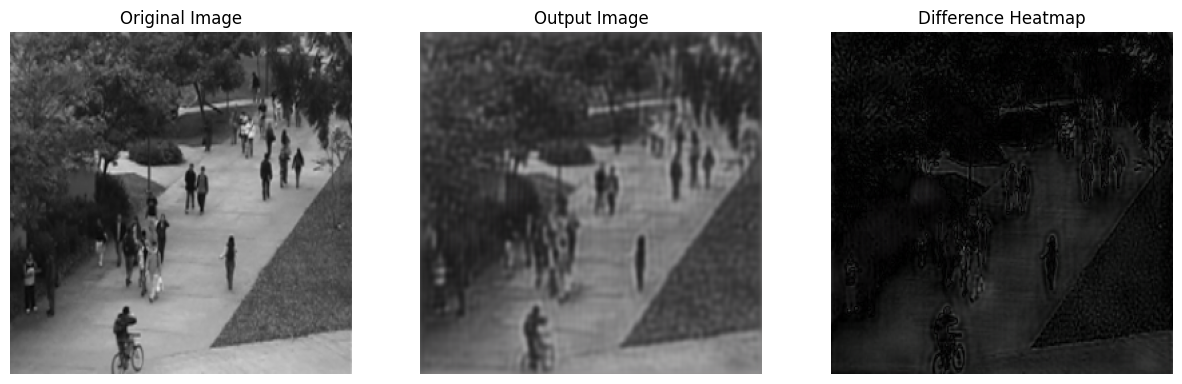

In [28]:


# Load one image for testing
image_path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/' + next(files_iter)
image = Image.open(image_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([ 
     transforms.Grayscale(num_output_channels=3),
     transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

image = transform(image).to(device)
image = image.unsqueeze(1).unsqueeze(1)  # Add a batch dimension at the front 
image = image.permute(1,2, 0, 3, 4)  # Rearranges to [1, 3, 158, 238, 1]

print(image.shape)
 
with torch.no_grad():
    output = model(image).to(device)
    print("Output shape:", output.shape)

# Convert to NumPy arrays for visualization
np_image = image.squeeze().cpu().numpy()
np_output = output.squeeze().cpu().numpy()

# If the images have channels as the first dimension, transpose them to (H, W, C)
if np_image.shape[0] in (1, 3):
    np_image = np_image.transpose(1, 2, 0)
if np_output.shape[0] in (1, 3):
    np_output = np_output.transpose(1, 2, 0)




# Calculate the absolute difference
difference = np.abs(np_image - np_output) 

# Calculate the MSE
mse = np.mean((np_image - np_output) ** 2)

print("Mean Squared Error:", mse)

# Create a heatmap to visualize the differences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np_output, cmap='gray')
plt.title('Output Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference, cmap='hot')
plt.title('Difference Heatmap')
plt.axis('off')

plt.show()



In [22]:
# Load Libraries

import os
from torchvision.datasets.folder import default_loader
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 
import torch.nn.functional as F
# Define your transformations
augment_transforms = [
    transforms.Compose([
        transforms.Resize((256, 256)),  # Resize if necessary
        transforms.ToTensor()           # Convert to tensor
    ]),
]

root_direct = os.path.dirname('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/')
sequences = []  # This will hold the training sequences

# Define the sequence function
def get_sequences_from_folder(folder_path, stride, sequence_length=10):
    image_files = sorted([file for file in os.listdir(folder_path) if file.endswith('.tif')])
    sequences = []
    for start_idx in range(0, len(image_files), stride * sequence_length):
        sequence_files = image_files[start_idx:start_idx + stride * sequence_length:stride]
        if len(sequence_files) == sequence_length:
            sequence = [default_loader(os.path.join(folder_path, f)) for f in sequence_files]
            transformed_sequence = [augment_transforms[0](img) for img in sequence]
            sequence_tensor = torch.stack(transformed_sequence, dim=0)
            sequences.append(sequence_tensor)
    return sequences

# Generate sequences with different strides
for subfolder in os.listdir(root_direct):
    subfolder_path = os.path.join(root_direct, subfolder)
    if os.path.isdir(subfolder_path):
        for stride in range(1, 3):  # Here, we use stride values of 1 and 2
            sequences.extend(get_sequences_from_folder(subfolder_path, stride))

# Stack all the sequences together to create the final dataset tensor
sequences_tensor = torch.stack(sequences, dim=0)
print(sequences_tensor.shape)

# Create the dataset from the tensor
dataset = TensorDataset(sequences_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


torch.Size([1020, 10, 3, 256, 256])


In [24]:

import torch.nn as nn
import torchvision.models as models


class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.gates = nn.Conv2d(in_channels=input_channels + hidden_channels,
                               out_channels=4 * hidden_channels,  # for input, forget, cell, and output gates
                               kernel_size=kernel_size,
                               padding=self.padding)

    def forward(self, input_tensor, hidden_state):
        h_cur, c_cur = hidden_state
        #print("[input_tensor, h_cur]", [input_tensor.size(), h_cur.size()])
        # concatenate along the channel dimension
        combined = torch.cat([input_tensor, h_cur], dim=1)
        gates = self.gates(combined)
        #print("[combined, gates]", [combined.size(), gates.size()])
        # Split the combined gate tensor into its components
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)
        #print("[input_gate, forget_gate, cell_gate, output_gate]", [input_gate.size(), forget_gate.size(), cell_gate.size(), output_gate.size()])

        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        output_gate = torch.sigmoid(output_gate)

        c_next = forget_gate * c_cur + input_gate * cell_gate
        h_next = output_gate * torch.tanh(c_next)
        #print("[h_next, c_next]", [h_next.size(), c_next.size()])
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device),
                torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device))


class ConvLSTM_VGG19(nn.Module):
    def __init__(self):
        super(ConvLSTM, self).__init__()

        # Load pre-trained VGG19 model
        vgg19 = models.vgg19(pretrained=True).features
        # Freeze the first half of the layers
        num_layers = len(vgg19)
        for layer in vgg19[:num_layers // 2]:  # Freeze the first half
            for param in layer.parameters():
                param.requires_grad = False
        self.vgg19_features = vgg19
        
        self.convlstm1 = ConvLSTMCell(input_channels=128, hidden_channels=64, kernel_size=3) # Adjust the input_channels based on VGG19 output
        self.convlstm2 = ConvLSTMCell(input_channels=64, hidden_channels=32, kernel_size=3)
        self.convlstm3 = ConvLSTMCell(input_channels=32, hidden_channels=64, kernel_size=3)

        # Spatial Decoder
        self.deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.5)

        self.deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=6, stride=2, padding=2, output_padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=11, padding=(11-1)//2) 

    def forward(self, x):
        b, seq_len, _, h, w = x.size()
        h1, c1 = self.convlstm1.init_hidden(b, (64, 64)) # Adjust the size as per the VGG19 output
        h2, c2 = self.convlstm2.init_hidden(b, (64, 64))
        h3, c3 = self.convlstm3.init_hidden(b, (64, 64))

        output_sequence = []

        for t in range(seq_len):
            # Pass through the VGG19 spatial encoder
            xt = self.vgg19_features(x[:, t]) 
            # Temporal Encoder
            h1, c1 = self.convlstm1(xt, (h1, c1))
            h2, c2 = self.convlstm2(h1, (h2, c2))
            h3, c3 = self.convlstm3(h2, (h3, c3))
            # Spatial Decoder 
            xt = self.deconv1(h3)
            xt = self.bn3(xt)
            xt = self.dropout3(xt)
            xt = F.relu(xt)
            
            xt = self.deconv2(xt)
            xt = self.bn4(xt)
            xt = self.dropout4(xt)
            xt = F.relu(xt)

            xt = torch.sigmoid(self.conv3(xt)) 
            output_sequence.append(xt.unsqueeze(1))

        output_sequence = torch.cat(output_sequence, dim=1)
        return output_sequence
            

model = ConvLSTM_VGG19()
image = torch.randn(1, 10, 3, 256, 256)

output = model(image)
print(output.size())


torch.Size([1, 10, 3, 256, 256])


In [31]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/ConvLSTM_experiment_1')


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Testing the dataset
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Instantiate the model
model = ConvLSTM()
model = nn.DataParallel(model)
model.to(device)

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5, eps=1e-6)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'ConvLSTM_VGG19_best.pth'  # Path to save the best model

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0

    for (images,) in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Training Loss: {average_loss:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (images,) in val_loader:
            images = images.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, images).item()

    val_loss /= len(val_loader)
    print(f'Validation Loss after Epoch {epoch+1}: {val_loss:.4f}')
    
    # Log training and validation loss
    writer.add_scalar('Loss/train', average_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    # Early stopping check and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print(f'Model saved at epoch {epoch + 1}')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch + 1}')
        break

# Load the best model after training
best_model = ConvLSTM()
best_model = nn.DataParallel(best_model)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()
# Now best_model holds the best model state

cuda
Epoch [1/20] Average Training Loss: 0.0180
Validation Loss after Epoch 1: 0.0132
Model saved at epoch 1
Epoch [2/20] Average Training Loss: 0.0054
Validation Loss after Epoch 2: 0.0058
Model saved at epoch 2
Epoch [3/20] Average Training Loss: 0.0036
Validation Loss after Epoch 3: 0.0045
Model saved at epoch 3
Epoch [4/20] Average Training Loss: 0.0029
Validation Loss after Epoch 4: 0.0034
Model saved at epoch 4
Epoch [5/20] Average Training Loss: 0.0025
Validation Loss after Epoch 5: 0.0031
Model saved at epoch 5
Epoch [6/20] Average Training Loss: 0.0023
Validation Loss after Epoch 6: 0.0029
Model saved at epoch 6
Epoch [7/20] Average Training Loss: 0.0020
Validation Loss after Epoch 7: 0.0027
Model saved at epoch 7
Epoch [8/20] Average Training Loss: 0.0019
Validation Loss after Epoch 8: 0.0027
Model saved at epoch 8
Epoch [9/20] Average Training Loss: 0.0017
Validation Loss after Epoch 9: 0.0026
Model saved at epoch 9
Epoch [10/20] Average Training Loss: 0.0016
Validation Loss

In [44]:
%load_ext tensorboard
%tensorboard --logdir runs



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
